<a href="https://colab.research.google.com/github/mohammedhemed77/NN-zero-to-hero-personal-practice/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

micro_grad Engine class

In [7]:
class Value :

  def __init__(self, data ,_children= (), _op='' ,label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda : None
    self._prev = set (_children)
    self.op = _op
    self.label= label

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data , (self,other),'+')
    # BP of addition

    def _backward():
      # d(out)/out = 1
      self.grad  += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__ (self,other):
    other = other if isinstance(other, Value) else Value (other)
    out = Value (self.data * other.data , (self,other), '*')
    # BP of Multiplication

    def _backward():
      self.grad  += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward

    return out


  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only support int / float"
    out =  Value (self.data**other,  (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out

  def __neg__(self):
    return self -1

  def __radd__(self,other):
    return self + other

  def __rsub__(self,other):
    return other + (-self)

  def __rmul__(self,other):
    return self * other

  def __truediv__(self ,other):
    return  self * (other ** -1)

  def __truediv__(self ,other):
    return  other * (self ** -1)

  def __repr__ (self):
    return f" Value (data = {self.data}, grad = {self.grad}) "

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out
  def backward (self):
    # topological order of all graph childs
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited :
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # go one variable at a time and apply the chain rule to get its gradient
    self.grad = 1.0
    for node in reversed (topo):
      node._backward()



Topological order of graph using Depth First Search


In [8]:
# Graph represented as an adjacency list
graph = {
    'A': ['C'],
    'B': ['C', 'D'],
    'C': ['E'],
    'D': ['F'],
    'E': ['H', 'F'],
    'F': ['G'],
    'G': [],
    'H': []
}

# List to store the topological order
topo_order = []

# Set to track visited nodes
visited = set()

# DFS function
def dfs(node):
    if node not in visited:
        visited.add(node)
        # Visit all children
        for neighbor in graph[node]:
            dfs(neighbor)
        # After visiting children, add the node to the topo_order
        topo_order.append(node)

# Perform DFS for each node
for node in graph:
    dfs(node)

# Reverse the order to get the correct topological sorting
topo_order.reverse()

# Output the topological order
print("Topological Order:", topo_order)

Topological Order: ['B', 'D', 'A', 'C', 'E', 'F', 'G', 'H']


In [9]:
class Node :

  def __init__ (self , name, _children = None):
    self.name = name
    self._prev = set(_children) if _children is not None else set()

  def __repr__(self) :
    return f"Node ({self.name} , {self._prev})"


# create nodes :

A = Node('A')
B = Node('B', _children = [A])
C = Node('C', _children = [A])
D = Node('D', _children = [B,C])
E = Node ('E',_children = [D])

topo = []
visited = set()

def build_topo(v,visited,topo):

  if v not in visited :
    visited.add(v)

    for child in v._prev :
      build_topo(child,visited,topo)
    topo.append(v)

build_topo(E,visited,topo)

# Print topological order
print("Topological Order:", [node.name for node in reversed (topo)])

Topological Order: ['E', 'D', 'B', 'C', 'A']



***graphviz API***

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if hasattr(n, '_op'):
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
     # Check if n2 has a '_op' attribute before using it to construct the edge name
    edge_name = str(id(n2)) + (n2._op if hasattr(n2, '_op') else '')
    dot.edge(str(id(n1)), edge_name)

  return dot

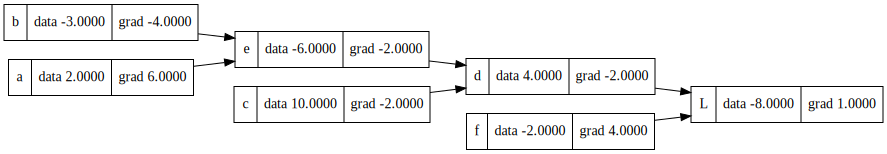

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.backward()
draw_dot(L)

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
# debug values of grad
print(x1.grad, x2.grad, w1.grad, w2.grad, b.grad)

-1.4999999999999996 0.4999999999999999 0.9999999999999998 0.0 0.4999999999999999


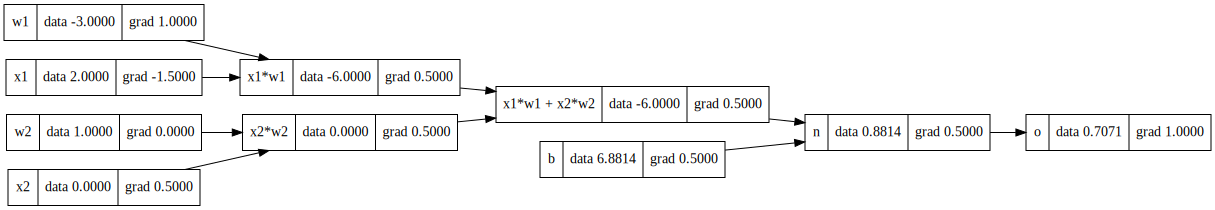

In [13]:
draw_dot(o)

In [14]:
import torch
x1 = torch.Tensor([2]).double()  ; x1.requires_grad = True
x2 = torch.Tensor([0]).double()  ; x2.requires_grad = True
w1 = torch.Tensor([-3]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1]).double()  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("-----")
print ('x1' , x1.grad.item())
print ('x2' , x2.grad.item())
print ('w1' , w1.grad.item())
print ('w2' , w2.grad.item())


0.7071066904050358
-----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


**Nueron Class**

In [17]:
class Nueron :

  def __init__ (self,num_inputs):
    self.w = [Value(random.uniform(-1,1)) for _ in range (num_inputs)]
    self.b = Value(random.uniform(-1,1))

  def __call__ (self,x):
    act = sum ((wi*xi for wi,xi in zip (self.w,x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer :

  def __init__ (self,num_inputs,num_out):
    self.neurons = [Nueron(num_inputs) for _ in range(num_out) ]

  def __call__ (self,x):
    out = [n(x) for n in self.neurons]
    return out

  def parameters(self):
    param = []
    for n in self.neurons :
      for p in n.parameters():
        param.append (p)

    return param


class MLP :

  def __init__(self , num_inputs,num_outs):
     sz = [num_inputs] + num_outs
     self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



# define complete nueral net :
# ----------------------------
# inputs = 3 , 3 layers : first one out = 4 , second out = 4 , last one = 1
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

for i in n.parameters() :
  print(i)

print ("number of parameters of the network : ",len(n.parameters()))
#nueron1 = [2.0 , 3.0]
#nueron2 = [3.0 , 5.0]

#layer = Layer(2 ,3)

#layer (nueron1)

#print (layer.parameters())



 Value (data = 0.6314324699328449, grad = 0) 
 Value (data = -0.016254124302273132, grad = 0) 
 Value (data = 0.37280967516048036, grad = 0) 
 Value (data = 0.26548981210491696, grad = 0) 
 Value (data = 0.02193265931421795, grad = 0) 
 Value (data = -0.7684825151927497, grad = 0) 
 Value (data = -0.6547427118480482, grad = 0) 
 Value (data = 0.8939691633558651, grad = 0) 
 Value (data = -0.4676285970550258, grad = 0) 
 Value (data = 0.5826182371110318, grad = 0) 
 Value (data = -0.9145060345787082, grad = 0) 
 Value (data = -0.6172323839284988, grad = 0) 
 Value (data = 0.31181452044030555, grad = 0) 
 Value (data = -0.4725648128554438, grad = 0) 
 Value (data = 0.27126593744973704, grad = 0) 
 Value (data = -0.377345720701749, grad = 0) 
 Value (data = 0.8558795413590754, grad = 0) 
 Value (data = 0.8590206724759231, grad = 0) 
 Value (data = -0.009108944426891474, grad = 0) 
 Value (data = 0.8026876062145987, grad = 0) 
 Value (data = -0.4732368422472084, grad = 0) 
 Value (data = 0